# A Chemical Classifier using a Computer Vision Classifier Model

Whilst completing lesson 1 of the [Fast.AI Deep Learning for Coders course](https://course.fast.ai), I was impressed by the examples of using image recognition for tasks not involving images. These included a student [beating the state-of-the-art enviromental sound detection by converting sounds to a spectrogram](https://etown.medium.com/great-results-on-audio-classification-with-fastai-library-ccaf906c5f52), olive oil classification, and fraud detection. I was interested in see if I could use this technique with images of chemical structures to classify chemical compounds as either acidic, basic, neutral, or a zwitterion.

## Preparing the data

I used data kindly supplied by [Cambridge Medchem Consulting](https://www.macinchem.org/reviews/ipython/calcproperties2.php), a library of 17034 compounds, each with an ABNZ (acid, base, neutral, zwitterion) label. The file was loaded into a pandas dataframe using RDKit.

In [1]:
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import PandasTools

In [2]:
df = PandasTools.LoadSDF('All_pKa_data.sdf')

[18:13:17] Can't kekulize mol.  Unkekulized atoms: 2 3 5 16 17 18 24 25 31 33
[18:13:17] ERROR: Could not sanitize molecule ending on line 1449941
[18:13:17] ERROR: Can't kekulize mol.  Unkekulized atoms: 2 3 5 16 17 18 24 25 31 33
[18:13:17] Can't kekulize mol.  Unkekulized atoms: 2 3 5 16 17 18 24 25 31 33
[18:13:17] ERROR: Could not sanitize molecule ending on line 1450328
[18:13:17] ERROR: Can't kekulize mol.  Unkekulized atoms: 2 3 5 16 17 18 24 25 31 33


Each entry had a lot of information, but for this classifier I only wanted the SMILES string and its ABNZ assignment.

In [3]:
df.columns

Index(['Name', 'NON_CHIRAL_CANONICAL_SMILES', 'STANDARD_SMILES', 'acid-base',
       'group', 'pka', 'pka_method', 'type', 'has_tautomer', 'has_duplicate',
       'has_stereoisomer', 'pka_list', 'ABNZ', 'id', 'apKa1', 'SMILES',
       'aroatoms_count', 'aromC_count', 'benzene_count', 'acetylene_count',
       'Allene_count', 'carbonyl_count', 'amide_count', 'PriAmide_count',
       'Lactam_count', 'urea_count', 'acid_count', 'acidHalide_count',
       'hyroxamic_count', 'ester_count', 'lactone_count', 'anhydride_count',
       'aldehyde_count', 'ketone_count', 'Unsatcarbonyl_count', 'ketene_count',
       'nitro_count', 'nitrile_count', 'oxime_count', 'Noxide_count',
       'quat_count', 'Narom_count', 'priAmine_count', 'secAmine_count',
       'tertAmine_count', 'aniline_count', 'Imine_count',
       'ImidoylHalide_count', 'amidine_count', 'guanidine_count',
       'Hydrazones_count', 'Semicarbazones_count', 'Diazo_count',
       'Isonitriles_count', 'Isocyanates_count', 'hydrox_count

In [4]:
data_clean = df[["STANDARD_SMILES","ABNZ"]].copy()

Whilst not completely balanced, there was plenty of examples of each type of compound. Balancing these using data augmentation may improve the model, but at this stage I just wanted to see if it would work at all.

In [5]:
data_clean.ABNZ.value_counts()

Neutral       6974
Base          5446
Acid          3478
Zwitterion    1136
Name: ABNZ, dtype: int64

In [6]:
data_clean.shape
# 17034 compounds

(17034, 2)

In [7]:
data_clean.isna().sum()
# No missing values

STANDARD_SMILES    0
ABNZ               0
dtype: int64

In [8]:
data_clean.duplicated().sum()
# Some duplicates, but at this stage I'm not sure it's a problem.

4139

For each compound, I used RDKit to create an RDKit object from the SMILES string, created an image of the structure, and saved in a folder assigned by its ABNZ label.

In [9]:
mol_list = [Chem.MolFromSmiles(x) for x in data_clean.STANDARD_SMILES]
data_clean['mol'] = mol_list

In [80]:
for index, row in data_clean.iterrows():
    ABNZ = row.ABNZ
    Chem.Draw.MolToFile(row.mol, f'./learning_images/{ABNZ}/{index}.png')    

,STANDARD_SMILES,ABNZ,mol
6212,Cc1n[nH]c(=NS(=O)(=O)c2ccc(O)cc2)s1,Acid,
4900,O=C(O)C(CO)NCc1cc(Cl)ccc1O,Zwitterion,
6801,OCCN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1,Base,
14227,Cc1cc(O)cc(O)c1,Neutral,
16714,C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2cc...,Base,

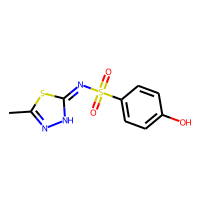
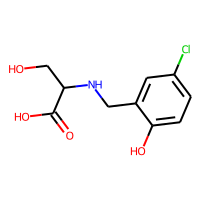
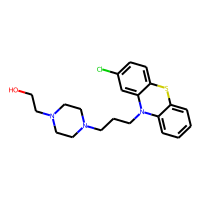
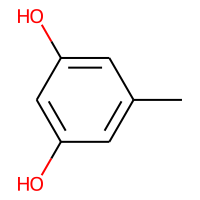
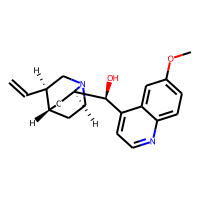

In [10]:
data_clean.sample(5)

## Building the model

With plenty of data, it was now time to train the model. The FastAI library makes training a CNN ridiculously easy. I first created a DataLoaders object which creates the training and validation sets, using a DataBlock.
The parameters needed are: 
* blocks: this specifies that out inputs are images, and the outputs are categories
* get_items: this collects the images
* splitter: splits the data into a training and validation set
* get_y: this labels the images according the the name of the folder they are saved in
* item_tfms: squishes the images to 192x192 pixels

We can then view a sample of the data used for training.

In [1]:
from fastai.vision.all import *

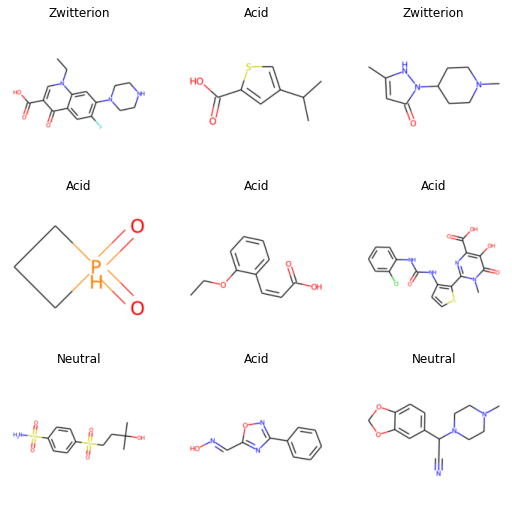

In [5]:
# Specify where to find the images to use for training the model
path = "./learning_images"

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=9)

Training our model is easy. FastAI has a fine_tune method which does it all for us. To begin with I'm using a fast, widely-used computer vision model called resnet18.

In [6]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(20)

/Users/jonswain/opt/anaconda3/envs/fastai_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/jonswain/opt/anaconda3/envs/fastai_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


epoch,train_loss,valid_loss,error_rate,time
0,1.176343,0.780232,0.312096,01:23


epoch,train_loss,valid_loss,error_rate,time
0,0.684131,0.503013,0.193188,02:42
1,0.431749,0.417083,0.151791,03:28
2,0.304971,0.391737,0.134469,03:36
3,0.242779,0.422375,0.133294,03:24
4,0.188358,0.495559,0.148268,03:26
5,0.198144,0.454375,0.129771,03:07
6,0.152085,0.440431,0.120669,02:36
7,0.111738,0.419722,0.110100,02:41
8,0.080940,0.447663,0.111568,02:46
9,0.063843,0.473781,0.105989,02:43


Even this simple model is 90% accurate as predicting ABNZ for chemical compounds. A few easy examples are shown below:

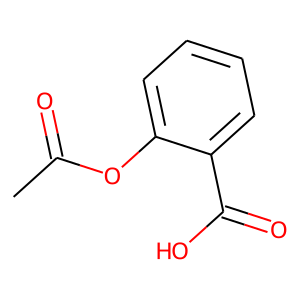

This is a: Acid.
Probability: 1.0000


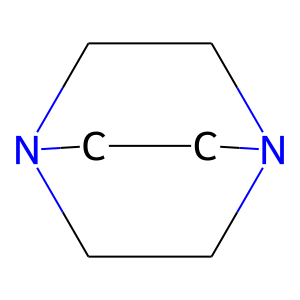

This is a: Base.
Probability: 1.0000


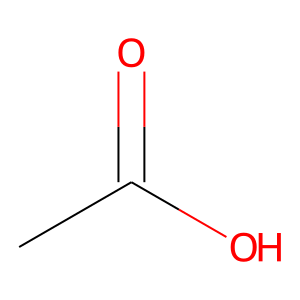

This is a: Acid.
Probability: 1.0000


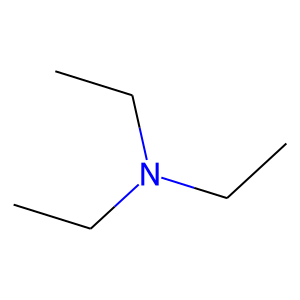

This is a: Base.
Probability: 1.0000


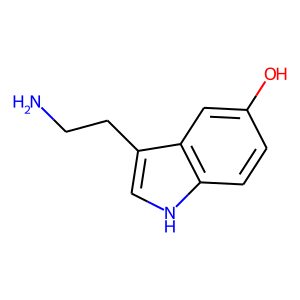

This is a: Base.
Probability: 1.0000


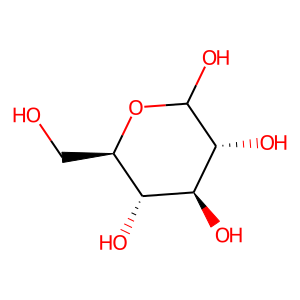

This is a: Neutral.
Probability: 0.9908


In [8]:
from PIL import Image

for count in range(0,6):
    category,_,probs = learn.predict(PILImage.create(f'./test/{count}.png'))
    image = Image.open(f'./test/{count}.png')
    display(image)
    print(f"This is a: {category}.")
    print(f"Probability: {probs[_]:.4f}")

For more complicated molecules it struggles mores:

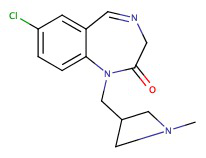

This is a: Neutral.
Probability: 0.9538


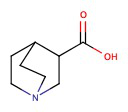

This is a: Acid.
Probability: 0.8788


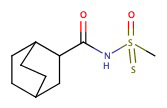

This is a: Neutral.
Probability: 0.6964


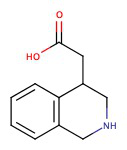

This is a: Base.
Probability: 0.6179


In [23]:
for count in range(0,4):
    category,_,probs = learn.predict(PILImage.create(f'./test/{count}.jpeg'))
    image = Image.open(f'./test/{count}.jpeg')
    display(image)
    print(f"This is a: {category}.")
    print(f"Probability: {probs[_]:.4f}")

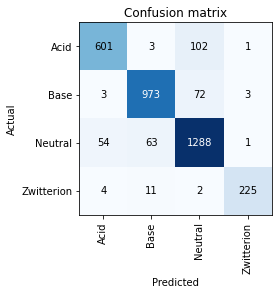

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

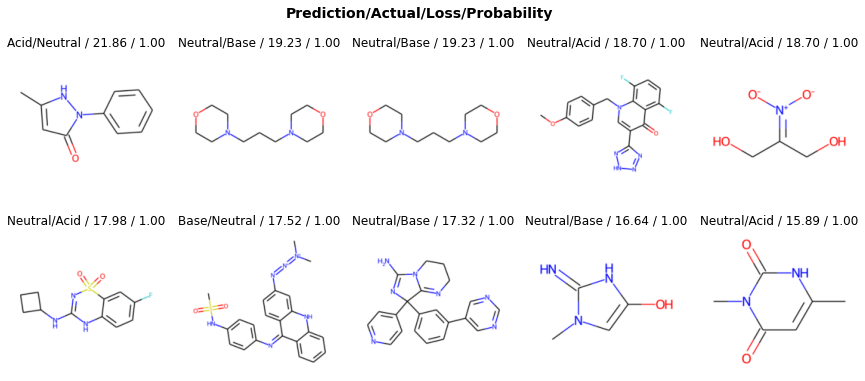

In [19]:
interp.plot_top_losses(10, nrows=2)